仓库地址：https://github.com/MiserableFaithAI/-.git

# Microsoft 资讯推荐

## 数据获取

In [1]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = '../../data/'
os.makedirs(temp_dir, exist_ok=True)

In [3]:
# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_dev.zip


['behaviors.tsv',
 'ca-GrQc.txt',
 'ca-GrQc.txt.gz',
 'cit-HepPh.txt',
 'cit-HepPh.txt.gz',
 'entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'news.tsv',
 'relation_embedding.vec']

In [2]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

In [3]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

## 数据预处理

In [4]:
behaviors.info()
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73152 entries, 0 to 73151
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   impression_id  73152 non-null  int64 
 1   user_id        73152 non-null  object
 2   time           73152 non-null  object
 3   history        70938 non-null  object
 4   impressions    73152 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42416 entries, 0 to 42415
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 42416 non-null  object
 1   category           42416 non-null  object
 2   subcategory        42416 non-null  object
 3   title              42416 non-null  object
 4   abstract           40395 non-null  object
 5   url                42416 non-null  object
 6   title_entities     42414 non-null  object
 7   abstr

对于behaviors，少量用户没有点击历史，且只有history存在缺失值，直接去除对应行

In [5]:
behaviors = behaviors.dropna(how='any')
behaviors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70938 entries, 0 to 73151
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   impression_id  70938 non-null  int64 
 1   user_id        70938 non-null  object
 2   time           70938 non-null  object
 3   history        70938 non-null  object
 4   impressions    70938 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.2+ MB


## 用户点击新闻类别频繁模式挖掘

对用户浏览的新闻记录进行频繁模式挖掘，对新闻的类别进行关联分析

- 提取新闻类别项集

In [7]:
def getSum(data):
    total = []
    for d in data:
        p = d.split(" ")
        total+=p
    return total

historys = behaviors.groupby('user_id').aggregate({'history': getSum})
historys = historys.reindex()

# 输入列名，提取用户点击新闻的类别或子类别
def loaditems(col_name = 'category'):

    historys_ = historys['history'].to_list()

    data_translation = []
    for h in historys_:
        items = [(news[news['id'] == i][col_name]).to_string().split("    ")[1] for i in h]
        data_translation.append(items)
    return data_translation

categories = loaditems()
"""subcategories = loaditems("subcategory")
print(subcategories[0:20])
print(categories[0:20])"""

'subcategories = loaditems("subcategory")\nprint(subcategories[0:20])\nprint(categories[0:20])'

In [48]:
df = pd.DataFrame({'historys': categories})
df.to_csv("../../data/historys.csv")

- Apriori算法

In [32]:
import pandas as pd

categories_data = pd.read_csv("../../data/historys.csv")
categories_str = categories_data['historys'].to_list()
categories = []
for c_str in categories_str:
    c_str = c_str[1:-1]
    word_list = c_str.split(',')
    words = [i.split('\'')[1] for i in word_list]
    categories.append(words)

print(categories[0])

['news', 'health', 'finance', 'news', 'news', 'news', 'foodanddrink', 'foodanddrink', 'news', 'news', 'lifestyle', 'sports']


In [42]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

c = [set(cate) for cate in categories]
# news 类型对于新闻类别没有任何意义，因此选择过滤news标签
for c_ in c:
    c_.discard('news')
print(c[0])

te = TransactionEncoder()
#进行 one-hot 编码
te_ary = te.fit(c).transform(c)
df = pd.DataFrame(te_ary, columns=te.columns_)
#利用 Apriori 找出频繁项集
freq = apriori(df, min_support=0.05, use_colnames=True)
print('===================频繁项集====================')
freq = freq.sort_values(by = 'support', ascending=False)
print(freq[:20])

#导入关联规则包
from mlxtend.frequent_patterns import association_rules
#计算关联规则
result = association_rules(freq, metric="confidence", min_threshold=0.7)
print('===================关联规则====================')
result = result.sort_values(by = 'confidence', ascending=False)
print(result[0:20])

{'finance', 'lifestyle', 'sports', 'foodanddrink', 'health'}
===================频繁项集====================
     support                   itemsets
5   0.671331                (lifestyle)
8   0.653036                   (sports)
10  0.620130                       (tv)
2   0.574815                  (finance)
67  0.476962            (lifestyle, tv)
65  0.457823        (sports, lifestyle)
4   0.446217                   (health)
82  0.439590               (sports, tv)
3   0.438849             (foodanddrink)
6   0.438026                   (movies)
38  0.437964       (finance, lifestyle)
41  0.418435          (finance, sports)
43  0.397547              (finance, tv)
1   0.370136            (entertainment)
55  0.367810        (lifestyle, health)
47  0.360011  (foodanddrink, lifestyle)
9   0.359681                   (travel)
7   0.356162                    (music)
0   0.350153                    (autos)
63  0.349948        (movies, lifestyle)
===================关联规则====================
           

输出置信度最高的前20条关联规则可以发现，这些频繁项集均与lifestyle类别有很强的关联性

- 可视化

对频繁项集中按支持度降序排列前100个频繁项集绘制词云

['lifestyle', 'sports', 'tv', 'finance', 'lifestyle', 'tv', 'sports', 'lifestyle', 'health', 'sports', 'tv', 'foodanddrink', 'movies', 'finance', 'lifestyle', 'finance', 'sports', 'finance', 'tv', 'entertainment', 'lifestyle', 'health', 'foodanddrink', 'lifestyle', 'travel', 'music', 'autos', 'movies', 'lifestyle', 'sports', 'lifestyle', 'tv', 'movies', 'tv', 'finance', 'lifestyle', 'tv', 'finance', 'sports', 'lifestyle', 'tv', 'health', 'sports', 'movies', 'foodanddrink', 'tv', 'foodanddrink', 'sports', 'sports', 'health', 'finance', 'foodanddrink', 'finance', 'health', 'finance', 'sports', 'tv', 'lifestyle', 'entertainment', 'finance', 'movies', 'travel', 'lifestyle', 'tv', 'entertainment', 'movies', 'lifestyle', 'tv', 'music', 'lifestyle', 'lifestyle', 'tv', 'health', 'music', 'tv', 'foodanddrink', 'lifestyle', 'tv', 'autos', 'lifestyle', 'finance', 'lifestyle', 'foodanddrink', 'finance', 'lifestyle', 'health', 'finance', 'travel', 'sports', 'autos', 'video', 'sports', 'music', 'spo

d:\Anaconda\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
d:\Anaconda\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
d:\Anaconda\lib\site-packages\wordcloud\wordcloud.py:523: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
d:\Anaconda\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
d:\Anaconda\lib\site-packages\wordcloud\wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecat

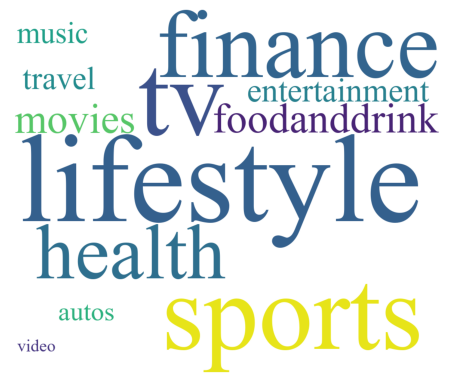

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_list = []
freqs = freq[:100]['itemsets'].tolist()
for i in freqs:
    for w in i:
        word_list.append(w)

print(word_list)
text_cut  =  '/'.join(word_list)
print(text_cut)
wordcloud = WordCloud(background_color='white',font_path="times.ttf", width=1000, height=860, margin=2).generate(text_cut)
# 显示图片 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

可见lifestyle、sports、TV、finance在频繁项集中出现次数较多，为热门新闻类别，且具有一定的相关度

选取置信度最高的30个关联规则进行可视化

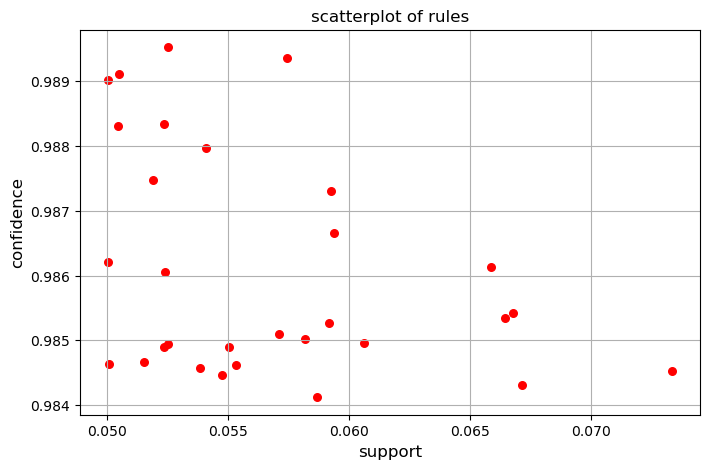

In [44]:
rules = result[:30]

rules.plot(kind="scatter",x = "support",c = "r",
           y = "confidence",s = 30,figsize=(8,5))
plt.grid("on")
plt.xlabel("support",size = 12)
plt.ylabel("confidence",size = 12)
plt.title("scatterplot of rules")
plt.show()

findfont: Font family ['STHeiti'] not found. Falling back to DejaVu Sans.


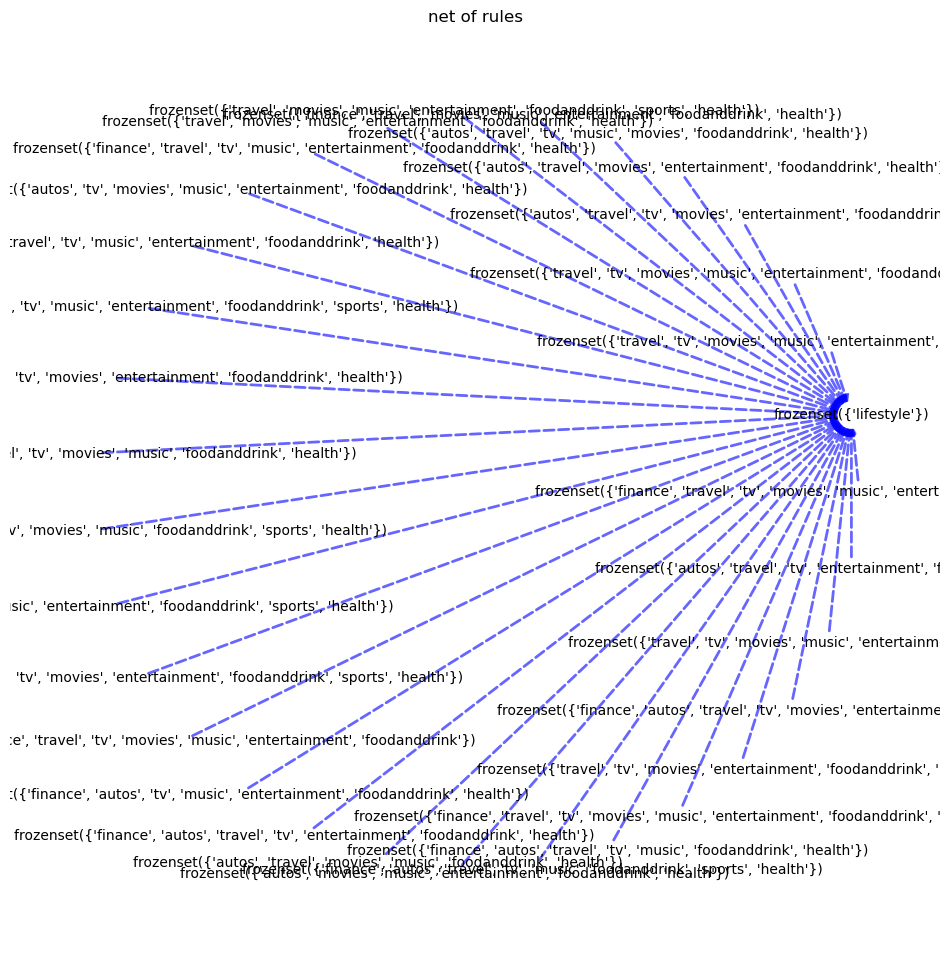

In [52]:
import networkx as nx
plt.figure(figsize=(12,12))
## 生成社交网络图
G=nx.DiGraph()

## 为图像添加边
for ii in rules.index:
    G.add_edge(rules.antecedents[ii],rules.consequents[ii],weight = rules.support[ii])
    
## 定义2种边
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.6]
emidle=[(u,v) for (u,v,d) in G.edges(data=True) if (d['weight'] <= 0.6)&(d['weight'] >= 0.45)]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= 0.45]

## 图的布局方式
pos=nx.circular_layout(G)

# 根据规则的置信度节点的大小

c = rules['confidence'] * 500

# nx.draw_networkx_nodes(G,pos,alpha=0.4, node_size=c.to_list())

# 设置边的形式
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=2,alpha=0.6,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=emidle,
                    width=2,alpha=0.6,edge_color='g',style='dashdot')
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=2,alpha=0.6,edge_color='b',style='dashed')

# 为节点添加标签
nx.draw_networkx_labels(G,pos,font_size=10,font_family="STHeiti")

plt.axis('off')
plt.title("net of rules")
plt.show()

由网络图可以观察出前30条关联规则均关于lifestyle，说明lifestyle类型新闻受众极广，大部分用户均会点击查看该类型的新闻。

# SNAP Arxiv GR-QC collaboration network

## 数据获取

直接下载，无需代码

## 数据预处理

In [ ]:
import pandas as pd

data_path = "../../data/ca-GrQc/CA-GrQc.txt"
with open(data_path, 'r') as f:
    data_lines = f.readlines()
data_lines = data_lines[4:]
data = []
for l in data_lines:
    str_ = l.split('\t')
    data.append([str_[0], str_[1][:-1]])
print(data)

## 作者合作模式

- 项集获取

将于同一作者合作过的关系进行合并，作为一个项目集

In [90]:
items = []
first_author = data[0][0]

item = [first_author]
for d in data:
    if d[0] == first_author:
        item.append(d[1])
    else:
        item = set(item)
        items.append(item)
        first_author = d[0]
        item = [d[1]]
items.append(item)
print(len(items))

5242


- 关联分析

In [85]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

te = TransactionEncoder()
#进行 one-hot 编码
te_ary = te.fit(items).transform(items)
df = pd.DataFrame(te_ary, columns=te.columns_)
#利用 Apriori 找出频繁项集
freq = apriori(df, min_support=0.01, use_colnames=True)
print('===================频繁项集====================')
freq = freq.sort_values(by = 'support', ascending=False)
print(freq[:20])

#导入关联规则包
from mlxtend.frequent_patterns import association_rules
#计算关联规则
result = association_rules(freq, metric="confidence", min_threshold=0.7)
print('===================关联规则====================')
result = result.sort_values(by = 'confidence', ascending=False)
print(result[0:20])

===================频繁项集====================
     support        itemsets
8   0.015452         (21012)
9   0.015071         (21281)
0   0.014689         (12365)
11  0.014689         (22691)
19  0.012972          (9785)
16  0.012972          (6610)
10  0.012781         (21508)
6   0.012591         (17655)
14  0.012400          (2741)
7   0.012018         (19423)
3   0.011828         (15003)
27  0.011637  (22691, 21012)
28  0.011446   (2741, 21012)
2   0.011446         (14807)
4   0.011255         (15244)
24  0.011064  (15003, 21508)
1   0.010874         (12781)
13  0.010683         (25346)
21  0.010683  (12365, 21508)
5   0.010683          (1653)
===================关联规则====================
       antecedents    consequents  antecedent support  consequent support  \
16   (15003, 9785)        (21508)            0.010492            0.012781   
17   (9785, 21508)        (15003)            0.010492            0.011828   
14          (7956)        (25346)            0.010683            0.01068

频繁项支持度较低，但关联规则置信度较高

- 可视化

关联规则散点图和网络图如下

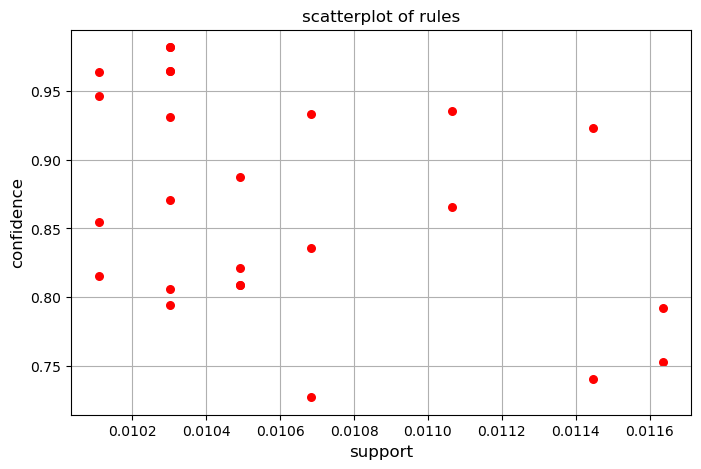

In [88]:
rules = result[:30]

rules.plot(kind="scatter",x = "support",c = "r",
           y = "confidence",s = 30,figsize=(8,5))
plt.grid("on")
plt.xlabel("support",size = 12)
plt.ylabel("confidence",size = 12)
plt.title("scatterplot of rules")
plt.show()

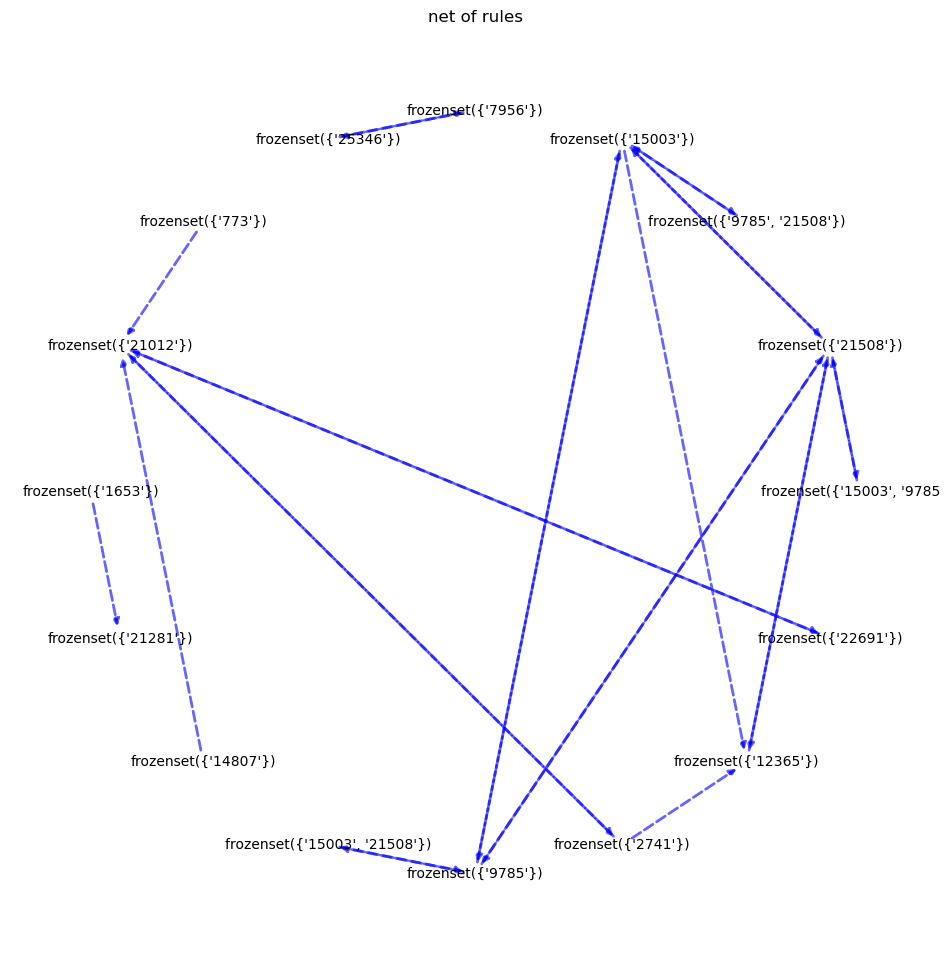

In [89]:
import networkx as nx
plt.figure(figsize=(12,12))
## 生成社交网络图
G=nx.DiGraph()

## 为图像添加边
for ii in rules.index:
    G.add_edge(rules.antecedents[ii],rules.consequents[ii],weight = rules.support[ii])
    
## 定义2种边
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.6]
emidle=[(u,v) for (u,v,d) in G.edges(data=True) if (d['weight'] <= 0.6)&(d['weight'] >= 0.45)]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= 0.45]

## 图的布局方式
pos=nx.circular_layout(G)

# 根据规则的置信度节点的大小

c = rules['confidence'] * 500

# nx.draw_networkx_nodes(G,pos,alpha=0.4, node_size=c.to_list())

# 设置边的形式
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=2,alpha=0.6,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=emidle,
                    width=2,alpha=0.6,edge_color='g',style='dashdot')
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=2,alpha=0.6,edge_color='b',style='dashed')

# 为节点添加标签
nx.draw_networkx_labels(G,pos,font_size=10,font_family="STHeiti")

plt.axis('off')
plt.title("net of rules")
plt.show()

id为21012、15003、21508与其他作者存在较高的关联度